### Librerias

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geemap,ee
import matplotlib.colors as colors
from shapely.geometry import shape, box
import shapely
from matplotlib import colors
import matplotlib.patches as mpatches

## 2. Datos.

Se trabajará con los datos de Landsat enfocados en la comuna de Machalí en la sexta región.

In [2]:
ee.Authenticate()

True

In [3]:
ee.Initialize(project='ee-dtperez1')

In [4]:
comuna = gpd.read_file('COMUNA_C17.shp').to_crs(4326)

In [5]:
machali = comuna[comuna['NOM_COMUNA'] == 'MACHALÍ']
lim_mac = machali.geometry
limites = box(-70.75, -34.25 , -70.6, -34.15)
mac = shapely.intersection(lim_mac, limites)
mac.crs = '4326'

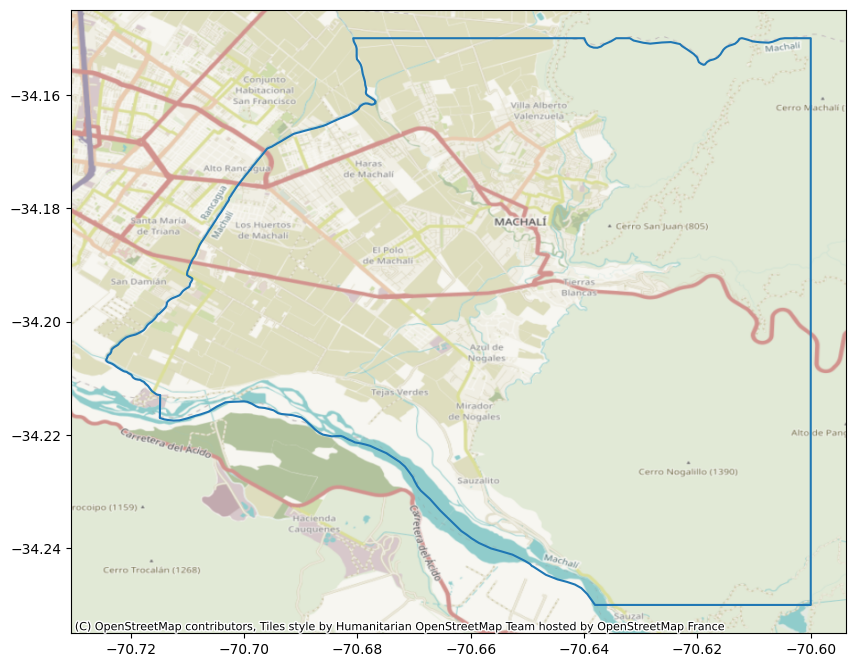

In [6]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
mac.boundary.plot(ax=ax)
ctx.add_basemap(ax,crs=comuna.crs.to_string())


In [7]:
minx,miny,maxx,maxy=mac.to_crs(4326).geometry.total_bounds
xy=[[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy]]

aoi = ee.Geometry.Polygon(xy)
aoi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -70.72431743399994,
              -34.25
            ],
            [
              -70.6,
              -34.25
            ],
            [
              -70.6,
              -34.15
            ],
            [
              -70.72431743399994,
              -34.15
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [8]:
collection = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2").filterBounds(aoi)
#collection = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(aoi)

In [9]:
images=collection.aggregate_array('system:id').getInfo()
images

['LANDSAT/LE07/C02/T1_L2/LE07_001084_20221127',
 'LANDSAT/LE07/C02/T1_L2/LE07_001084_20230208',
 'LANDSAT/LE07/C02/T1_L2/LE07_001084_20231114',
 'LANDSAT/LE07/C02/T1_L2/LE07_001084_20240117',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_20071123',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_20071209',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_20071225',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_20090520',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_20100115',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_20100131',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_20100216',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_20100304',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_20100320',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_20100405',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_20120426',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_20120528',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_20140126',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_20140211',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_20171102',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_20171118',
 'LANDSAT/LE07/C02/T1_L2/LE07_232084_201

In [10]:
imagen = ee.Image(images[250])
len(images)


498

In [19]:
import geemap.colormaps as cm
Map = geemap.Map(center=[0.5 * (miny + maxy),0.5 * (minx + maxx)], zoom=12)


vis_params = {"min": 65455/20, "max": 65455/4, "bands": ["SR_B1", "SR_B2", "SR_B3"]}

#vis_params = {"min": 0, "max": 4000, "bands": ["B3", "B4", "B2"]}

Map.addLayer(imagen, vis_params,name='Imagen')

Map.addLayer(aoi,name='aoi',shown=True, opacity = 0.5)

Map

Map(center=[-34.2, -70.66215871699997], controls=(WidgetControl(options=['position', 'transparent_bg'], widget…

In [12]:
def fmask(image):
       qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
       opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
       return image.addBands(opticalBands, None, True).updateMask(qaMask)

In [13]:
fmask(imagen)